## Motion Planning, Assignment 2:

# Vehicle kinematics model and Stanley controller

The objective of this assignment is the implementation of a Stanley controller for simple path following. To develop this controller, you will start off writing a kinematic simulation model of a vehicle based on the bicylce model. Hints on using Python and Jupyter notebooks can be found on the course's Moodle page. 

## 1. Preparation: load and display the target trajectory

Load all required standard libs:

In [1]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

And upload the reference path to Colab:

In [ ]:
# Upload data file - Colab ONLY!
# coursedata.npz
from google.colab import files#

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))

You can load the reference path data using:

In [3]:
trkdata = np.load('coursedata.npz')
print(trkdata.files)

['x', 'y', 'yaw', 'curvature', 's']


## Ex 1.1

Make sure you understand the meaning of the elements of the path (note: ```curvature``` is the reciprocal of the circle radius ```r```). Draw the reference path using the command ```plt.plot```.

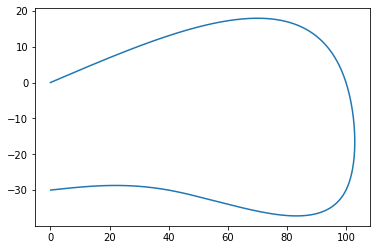

In [4]:
## INSERT CODE HERE
plt.plot(trkdata['x'], trkdata['y'])

## 2. Lateral acceleration

To make sure the vehicle can be operated safely, it should leave a significant margin to the its dynamic limits. This implies that the operation points of the vehicle should be placed well inside of **Kamm's Circle** (as described in the lecture slides).

We assume, that the desired path shall be travelled with constant longitudinal velocity  
(i.e. longitudinal acceleration $a_x = 0$), and that for stable operation, the lateral acceleration should never exceed $6 m/s^2$. 

## Ex 2.1

Based on these assumptions, you can derive an upper limit ```v_desired``` of the vehicle's velocity that the vehicle can drive without violating the max. admissable lateral acceleration:
1. At first, let ```v_desired=40km/h```. 
2. For this speed, compute the resulting lateral acceleration $a_y$ along the reference path. You may use the approximate formula for driving a circular path with constant velocity (cf. lecture slides): 

\begin{eqnarray} \dot{\psi} &=& v_{soll} \, / \, r \\
\rightarrow \;\;\;\; a_y &=& v_{desired} \,\dot{\psi} = v_{desired}^2 \, / \, r 
\end{eqnarray} 

and using curvature $\kappa = 1/r$: 

\begin{equation}
a_y = v_{desired}^2 \, \kappa \,.
\end{equation} 

Visualize $a_y$ using ```plt.plot```. Can the vehicle drive the reference path at ```v_desired=40km/h``` without violating the lateral acceleration constraint?
3. By testing various velocitys, find the highest desired speed ``v_desired`` at which the vehicle can still safely drive along the path.

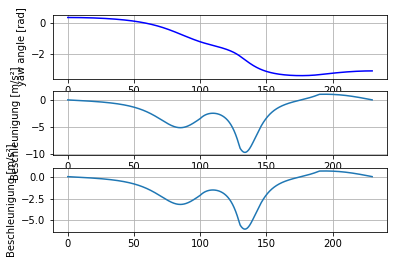

In [9]:
plt.subplot(3,1,1)
plt.plot(trkdata['s'], np.unwrap(trkdata['yaw']), "b", label="yaw")
plt.ylabel("yaw angle [rad]")
plt.grid(True)

plt.subplot(2,1,2)

## INSERT CODE HERE
v_soll = 40 / 3.6
plt.subplot(3,1,2)
ay = v_soll**2 * trkdata['curvature']
plt.plot(trkdata['s'], ay)
plt.ylabel("Beschleunigung [m/s²]")
plt.grid(True)

plt.subplot(3,1,3)
v_desired = np.sqrt(-6 / trkdata['curvature'][np.argmax(abs(ay))])
ay_max = v_desired**2 * trkdata['curvature']
plt.plot(trkdata['s'], ay_max)
plt.ylabel("Beschleunigung [m/s²]")
plt.grid(True)

## 3. Kinematic vehicle model

The foundation for evaluating a controller is a suitable model of the plant. Here, we first employ a simplified kinematic model of a driving a constant circular path without side slip angles.

For small steering angles, we have (cf lecture slides on Ackermann angle):
$$
\tan \delta_A = L / r
$$
Using the yaw rate
$$
\dot{\psi} = v / r
$$
we get 
$$
\dot{\psi} = \frac{v}{L} \tan \delta_A \;. 
$$

We will use the function [odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to simulate the kinematic model. This function requires the time derivatives of all relevant state components. Since $\dot{\psi}$ is already available, we still need the derivatives $\dot{x}, \dot{y},$ and $\dot{v}$.

From the following Figure

![SimpleVehiclePose.png](https://drive.google.com/uc?id=1I-QTvM15N7ilJ9TWuaXYlM67ptnkGzq8)

we can easily obtain these derivatives using the yaw angle $\psi$:
$$
\begin{eqnarray}
        \dot{x} &=& v \cos \psi  \\
        \dot{y} &=& v \sin \psi  \\
        \dot{\psi} &=& \frac{v}{L} \tan \delta_A \\
        \dot{v} &=& a 
\end{eqnarray}$$

where $a$ denotes the longitudinal acceleration of the vehicle. 

## Ex 3.1

Use these formulae to complete the code for the vehicle model below. Please consider the following hints:

* Both the steering angle and the acceleration are bounded in a real vehicle. Thus, limit the desired steering angle (using $|\delta_A|$ < ``max_steer``) as well as the desired longitudinal acceleration (using ``min_ax`` < $a_x$ < ``max_ax``) in your model.
* It is helpful to normalize the angles in your model to the range $[-\pi, \pi]$. You may use the function ``normalize_angle(angle)`` for this.   
* For brevity, you may omit checking whether the vehcile's acceleration lies within Kamm's circle in this excercise. 

Test your code by running several simulations with different commanded signals.

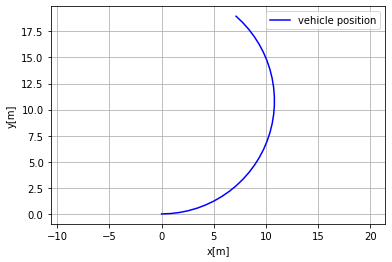

In [11]:
dT = 0.1  # [s] time difference
L = 2.9  # [m] Wheel base of vehicle
veh_dim_x, veh_dim_y = 4, 1.9  # [m] size of vehicle (length, width)
max_steer = np.radians(30.0)  # [rad] max steering angle
max_ax = 2 # [m/ss] max (positive) acceleration
min_ax = -10 # [m/ss] max decceleration (=min negative acceleration)

# sluggish vehicle (only needed for optional excercise):
m = 1800 # [kg] mass
J = 3000 # moment of inertia [kg/m2]
lv = 1.3 # distance COG to front axle [m]
lh = 1.6 # distance COG to rear axle [m]
cav= 2*60000 # lateral tire stiffness front [N/rad]
cah = 2*60000 # lateral tire stiffness rear [N/rad]

def normalize_angle(angle):
    """ Normalize an angle to [-pi, pi]. """
    return (angle + np.pi) % (2 * np.pi) - np.pi

class State():
    """
    Class representing the state of a vehicle.

    :var t: (float) current time
    :var x: (float) x-coordinate
    :var y: (float) y-coordinate
    :var yaw: (float) yaw angle
    :var v: (float) speed

    For the second part of the excercise (one track dynamics model), 
    you additionally need two more state components:
    
    :var beta: (float) slip angle
    :var dyaw_dt: (float) time derivative of slip angle
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0, t=0.0):
        """Instantiate the object."""
        super(State, self).__init__()
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.t = t
        
        self.beta = 0
        self.dyaw_dt = 0
    
    def kinematic_model(self, state, t, acceleration, delta): 
        """Kinematic vehicle model.
        This function is to be used in odeint and has 
        form "dstate_dt = f(state,t)". 
        """
        x, y, yaw, v = state
        
        ## INSERT CODE HERE
        dx_dt = v*np.cos(yaw)
        dy_dt = v*np.sin(yaw)
        dyaw_dt = v*np.tan(delta)/L
        dv_dt = acceleration

        ## END INSERTED CODE

        dstate_dt = [dx_dt, dy_dt, dyaw_dt, dv_dt]
        return dstate_dt
        
    def update(self, acceleration, delta):
        """
        Update the state of the vehicle.
        
        :param acceleration: (float) Acceleration
        :param delta: (float) Steering
        """
        ## INSERT CODE HERE
        
        #...
        delta = np.clip(delta, -max_steer, max_steer)
        acceleration = np.clip(acceleration, min_ax, max_ax)
        state0 = [self.x, self.y, self.yaw, self.v] # replace this line
        ti = [self.t, self.t+dT]
        sol = odeint(self.kinematic_model, state0, ti, args=(acceleration, delta))

        self.x, self.y, self.yaw, self.v = sol[1]
        self.yaw = normalize_angle(self.yaw)
        self.t = ti[1]
        ## END INSERTED CODE
        
    def dynamic_model(self, state, t, acceleration, delta): 
        """Model for the lateral and yaw dynamics of the bicylce model
        (only needed for optional excercise).
        
        This function is to be used in odeint and has 
        form "dstate_dt = f(state,t)". 
        """
        x, y, yaw, v, beta, dyaw_dt = state
        
        ## INSERT CODE HERE
        
        dbeta_dt = - (cav+cah)/(m*v)*beta - (1+(cav*lv-cah*lh) /
                                             (m*v**2))*dyaw_dt + cav/(m*v)*delta
        ddyaw_dt2 = - (cav*lv-cah*lh)/J*beta - (cav*lv**2 +
                                                cah*lh**2)/(J*v)*dyaw_dt + cav*lv/J*delta

        dx_dt = v*np.cos(yaw+beta)
        dy_dt = v*np.sin(yaw+beta)
        dyaw_dt = dyaw_dt
        dv_dt = acceleration
        ## END INSERTED CODE
        
        dstate_dt = [dx_dt, dy_dt, dyaw_dt, dv_dt, dbeta_dt, ddyaw_dt2]
        return dstate_dt
        
    def update_dynamic_model(self, acceleration, delta):
        """
        Update the state of the vehicle (only needed for optional excercise).
        
        :param acceleration: (float) Acceleration
        :param delta: (float) Steering
        """
        ## INSERT CODE HERE
        
        # ...
        state0 = [self.x, self.y, self.yaw, self.v, self.beta, self.dyaw_dt] # replace this line
        ti = [self.t, self.t+dT]
        sol = odeint(self.dynamic_model, state0, ti, args=(acceleration, delta))

        self.x, self.y, self.yaw, self.v, self.beta, self.dyaw_dt = sol[1]
        self.yaw = normalize_angle(self.yaw)
        self.beta = normalize_angle(self.beta)
        self.t = ti[1]
        ## END INSERTED CODE

        
## MODIFY HERE FOR EVALUATION
S = State(v=v_desired)
x, y = [S.x], [S.y]
for i in range(30):
    S.update(acceleration=0, delta=np.radians(15.0))
    x.append(S.x)
    y.append(S.y)
    
plt.plot(x, y, "b", label="vehicle position")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)

## Ex 3.2 (optional)

As an optional excercise, you may implement the dynamic bicycle model with side slip angle $\beta$ and yaw rate $\dot{\psi}$ as discussed in the lecture. Modify the functions ``dynamic_model`` and ``update_dynamic_model`` for this and adapt the visualization code above.

## 4. Longitudinal control

Implement a simple P-controller for longitudinal control. The input for the longitudinal controller shall be the desired velocity and the current (actual) velocity.

## Ex 4.1

Complete the code below. 

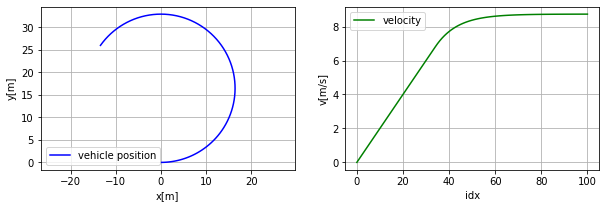

In [20]:
Kp = 1.0  # speed propotional gain

def speed_control(target, current):
    """
    Proportional control for the speed.
    :param target: target speed (m/s)
    :param current: current speed (m/s)
    :return: controller output (m/ss)
    """
    ## INSERT CODE HERE
    return (target - current)*Kp
    
    ## END INSERTED CODE

S = State(v=0)
x, y, v = [S.x], [S.y], [S.v]
for i in range(100):
    acc = speed_control(v_desired, S.v)
    S.update(acceleration=acc, delta=np.radians(10.0))
    x.append(S.x)
    y.append(S.y)
    v.append(S.v)
    
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(x, y, "b", label="vehicle position")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)  

plt.subplot(1,2,2)
plt.plot(v, "g", label="velocity")
plt.legend()
plt.xlabel("idx")
plt.ylabel("v[m/s]")
plt.grid(True)

## 5. Lateral control using the Stanley method

For running the lateral controller, we need to compute the current lateral offset from the vehicle's current position and the desired reference path:
![calcIndex.png](https://drive.google.com/uc?id=1mDOq3lLrQPgraxkdItuuFBBq5bii9sNx)

This can be done with function ```calc_target_index(state, cx, cy, cyaw)```.
Read and understand the code below.

In [19]:
def calc_target_index(state, cx, cy, cyaw):
    """
    Compute index in the trajectory list of the target.

    :param state: (State object)
    :param cx: [m] x-coordinates of (sampled) desired trajectory
    :param cy: [m] y-coordinates of (sampled) desired trajectory
    :param cyaw: [rad] tangent angle of (sampled) desired trajectory
    :return: (int, float)
    """
    # Calc front axle position
    fx = state.x + 0.5 * L * np.cos(state.yaw)
    fy = state.y + 0.5 * L * np.sin(state.yaw)

    # Search nearest point index
    dx_vec = fx - np.asarray(cx).reshape([-1,1])
    dy_vec = fy - np.asarray(cy).reshape([-1,1])
    dist = np.hstack([dx_vec, dy_vec])
    dist_2 = np.sum(dist**2, axis=1)
    target_idx = np.argmin(dist_2)

    # Project RMS error onto front axle vector
    front_axle_vec = [np.cos(cyaw[target_idx] + np.pi / 2),
                      np.sin(cyaw[target_idx] + np.pi / 2)]
    error_front_axle = np.dot(dist[target_idx,:], front_axle_vec)

    return target_idx, error_front_axle

## Ex 5.1

Using the lecture slides, complete the code for the Stanley controller below.

Note: Make sure to normalize the difference in angles $\psi_d$ using the function ```normalize_angle```.

In [21]:
k = 0.7  # control gain

def stanley_control(state, cx, cy, cyaw, last_target_idx):
    """
    Stanley steering control.

    :param state: (State object)
    :param cx: [m] x-coordinates of (sampled) desired trajectory
    :param cy: [m] y-coordinates of (sampled) desired trajectory
    :param cyaw: [rad] orientation of (sampled) desired trajectory
    :param last_target_idx: [int] last visited point on desired trajectory
    :return: ([rad] steering angle, 
        [int] last visited point on desired trajectory, 
        [m] cross track error at front axle)
    """
    current_target_idx, error_front_axle = calc_target_index(state, cx, cy, cyaw)

    # make sure that we never match a point on the desired path 
    # that we already passed earlier:
    if last_target_idx >= current_target_idx:
        current_target_idx = last_target_idx

    ## INSERT CODE HERE

    delta = normalize_angle(cyaw[current_target_idx] - state.yaw) + np.arctan2(-k * error_front_axle, state.v)
    ## END INSERTED CODE

    return delta, current_target_idx, error_front_axle

## Ex 6.1 (Putting it all together)

Combine both controllers to follow the given path. Examine the resulting lateral deviations.

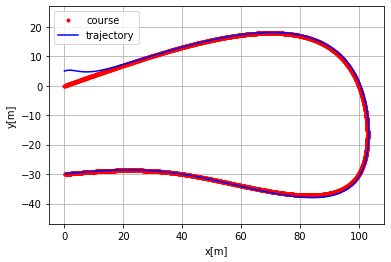

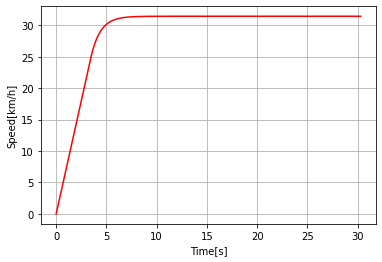

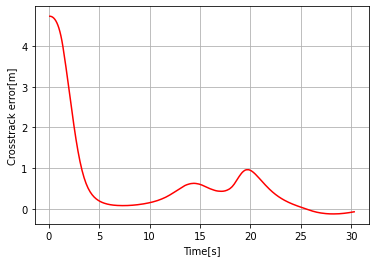

In [22]:
from re import T


target_speed = v_desired
max_simulation_time = 100.0

# Initial state
state = State(x=-0.0, y=5.0, yaw=np.radians(20.0), v=0.0)

last_idx = len(trkdata['x']) - 1
time = 0.0
x = [state.x]
y = [state.y]
v = [state.v]
yaw = [state.yaw]
t = [state.t]
e_track = [np.nan]
target_idx, _ = calc_target_index(state, trkdata['x'], trkdata['y'], trkdata['yaw'])

while max_simulation_time >= state.t and last_idx > target_idx:
    ## INSERT CODE HERE
    ai = speed_control(target=target_speed,current=v[-1])
    di, target_idx, dlat = stanley_control(state=state, cx=trkdata['x'], cy=trkdata['y'], cyaw=trkdata['yaw'],last_target_idx=target_idx)
    ## END INSERTED CODE
    state.update(ai, di)

    x.append(state.x)
    y.append(state.y)
    v.append(state.v)
    yaw.append(state.yaw)
    t.append(state.t)
    e_track.append(dlat)

# Test
assert last_idx >= target_idx, "Cannot reach goal"

plt.plot(trkdata['x'], trkdata['y'], ".r", label="course")
plt.plot(x, y, "-b", label="trajectory")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)

plt.subplots(1)
plt.plot(t, [iv * 3.6 for iv in v], "-r")
plt.xlabel("Time[s]")
plt.ylabel("Speed[km/h]")
plt.grid(True)

plt.subplots(1)
plt.plot(t, e_track, "-r")
plt.xlabel("Time[s]")
plt.ylabel("Crosstrack error[m]")
plt.grid(True)

## 7. Animation

The next cells create an animation that demonstrates how the vehicle will drive along the given path.

In [23]:
def getVehicleContours(pos_x, pos_y, yaw):
    """Compute object contours."""

    L_2, W_2 = veh_dim_x/2.0, veh_dim_y/2.0
    u = np.array([
        [0, -W_2, 1],    # 1
        [L_2, -W_2, 1],  # 2
        [L_2, W_2, 1],   # 3
        [0, W_2, 1],     # 4
        [L_2, 0, 1],     # 5
        [0, -W_2, 1],    # 6
        [0, W_2, 1],     # 7
        [-L_2, W_2, 1],  # 8
        [-L_2, -W_2, 1],  # 9
        [0, -W_2, 1]     # 10
    ]).T

    T = np.array([
        [np.cos(yaw), -np.sin(yaw), pos_x],
        [np.sin(yaw), np.cos(yaw), pos_y]
    ])

    v = np.dot(T, u)
    return v[0, :], v[1, :]

In [25]:
# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots(figsize=(8,8))
plt.close()
ax.axis("equal")
ax.grid(True)
ax.set_xlim((-10, 110))
ax.set_ylim((-60, 60))
course, = ax.plot([], [], "r.", label="course")
trajectory, = ax.plot([], [], "-b", label="trajectory")
vehicle, = ax.plot([], [], "b", label="vehicle")
title_text = ax.text(.7, .9, '', transform = ax.transAxes)

# initialization function: plot the background of each frame
def init():
    course.set_data(trkdata['x'], trkdata['y'])   
    return (course,)
  
# animation function: this is called sequentially
def animate(i):
    trajectory.set_data(x[:i], y[:i])
    px, py = getVehicleContours(x[i], y[i], yaw[i])
    vehicle.set_data(px, py)
    title_text.set_text(("Speed[km/h]:" + str(v[i] * 3.6)[:4]))
    return (trajectory, vehicle, title_text, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(x), 
                               interval=50, blit=True)

rc('animation', html='jshtml')
anim

## Potential extensions

If you have more time, you can optimize the controller given above for faster driving. Here are some potential next steps:

1. Compute the max. allowed velocity $v_{max}(s)$ along the reference path based on the lateral acceleration $a_y(s)$ ($s$: distance driven).

2. Add a preview distance to the longitudinal controller.

3. Adapt the simulation code above such that the longitudinal controller sets the fastest possible velocities at each point of the path. Make sure that the max. lateral acceleration is not exceeded.